<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#mlp-regression" data-toc-modified-id="mlp-regression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>mlp regression</a></span><ul class="toc-item"><li><span><a href="#regularization-&amp;-hyperparameters-tuning" data-toc-modified-id="regularization-&amp;-hyperparameters-tuning-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>regularization &amp; hyperparameters tuning</a></span></li></ul></li><li><span><a href="#pinn" data-toc-modified-id="pinn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>pinn</a></span></li></ul></div>

# tl;dr

In this notebook we will try to write code for a PINN that solves the Damped Harmonic Oscillator problem. We will not use the parameter learning approach. Instead, we will use a MLP to learn the solution of the DHO problem. Then, we turn the MLP in a PINN by adding the DHO PDE as a loss function.

The goal here is not to get the best results, but to get a working code that we can use as a starting point for the parameter learning approach.

# setup

In [1]:
import pprint
import functools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from IPython.display import display

%matplotlib inline

# data

<!-- **medidas** <br/> de [Lab 6: Simple Harmonic Oscillators](https://www.studocu.com/en-us/document/the-city-college-of-new-york/general-physics-i/lab-6-simple-harmonic-oscillators/27226380)

| $Time(s)$ | $Position (m)$ | $Velocity (m s^{-1})$ | Acceleration ($m s^{-2}$) |
|:-----------:|:---------------:|:-----------------:|:-----------------------:|
|      0      |     0.181104    |     -0.003521     |        0.0107877        |
|     0.5     |    0.1808296    |      -0.00048     |        -0.016009        |
|      1      |    0.1808296    |     0.0563435     |        0.9898961        |
|     1.5     |    0.2458624    |     0.0782269     |         1.068586        |
|      2      |     0.208544    |     -0.279888     |         0.698207        |
|     2.5     |    0.1808296    |     0.0872821     |        1.2009078        |
|      3      |     0.297724    |     0.0721215     |         -1.22394        |

Spring Constant: k = 16.16
Length of Spring: 0.18m
Length of Spring (Stretched): 0.787m
X= 0.607 

data = [
    [0, 0.181104, -0.003521, 0.0107877],
    [0.5, 0.1808296, -0.00048, -0.016009],
    [1, 0.1808296, 0.0563435, 0.9898961],
    [1.5, 0.2458624, 0.0782269, 1.068586],
    [2, 0.208544, -0.279888, 0.698207],
    [2.5, 0.1808296, 0.0872821, 1.2009078],
    [3, 0.297724, 0.0721215, -1.22394]
]

pd.DataFrame(data, columns=["t", "x", "v", "a"])
-->

**medidas** <br/> [Damped Harmonic Oscillator Dataset by Cecília Coelho](https://www.kaggle.com/datasets/cici118/damped-harmonic-oscillator)

* $m = 1kg$
* $k = 1 N m^{-1}$
* $\mu = 0.1 N s m^{-1}$
* $x_0 = 1 m$
* $v_0 = 0 m s^{-1}$

,time,displacement,velocity,acceleration
0,0.000000,1.000000,0.000000,-1.000000
1,1.507538,0.106701,-0.926586,-0.014042
2,3.015075,-0.847175,-0.111879,0.858363
3,4.522613,-0.194060,0.783410,0.115719
4,6.030151,0.705190,0.190814,-0.724272
5,7.537689,0.252050,-0.650740,-0.186976
6,9.045226,-0.576071,-0.242684,0.600339
7,10.552764,-0.286335,0.530372,0.233298
8,12.060302,0.460883,0.272761,-0.488160
9,13.567840,0.301914,-0.423218,-0.259593


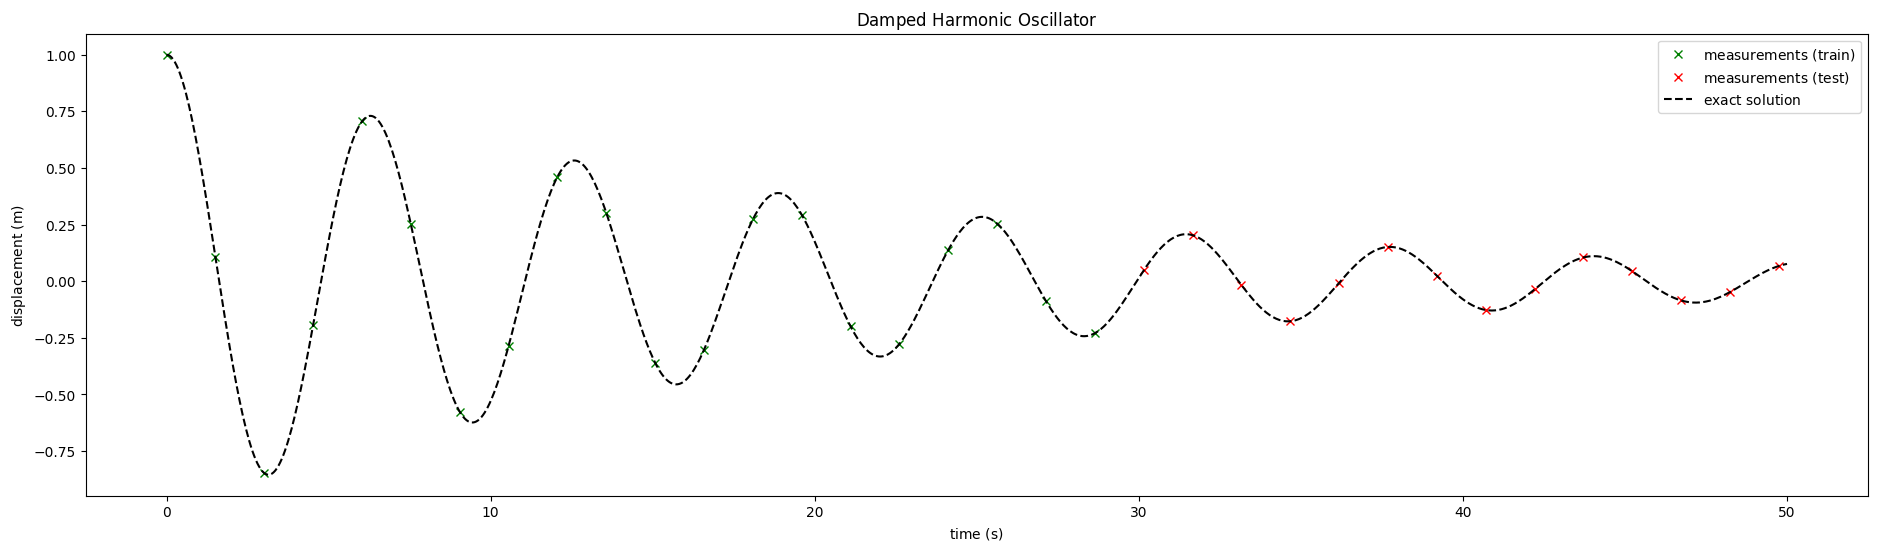

In [2]:
X = pd.read_csv("../data/01_raw/damped-harmonic-oscillator/extrapolation/train.csv").query("time <= 50")
display(X)

# plot experimental data
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 30").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 30 and time <= 50").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

# plot theoretical curve
m = 1
k = 1
mu = 0.1
x_0 = 1
v_0 = 0

omega_0 = np.sqrt(k/m)
delta = mu/(2*m)
omega = np.sqrt(omega_0**2 - delta**2)

t = np.linspace(0, 50, 1000)
x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
ax1.plot(
    t, 
    x, 
    c="k", linestyle="--", 
    label=r"$\text{exact solution}$"
)

ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

ax1.legend()

plt.savefig("../data/08_reporting/figures/oscilador_harmonico.png", dpi=300, bbox_inches="tight") ;

In [3]:
x_train = torch.tensor(X.query("time <= 30")["time"].values).float().unsqueeze(1)
y_train = torch.tensor(X.query("time <= 30")["displacement"].values).float().unsqueeze(1)

x_test = torch.tensor(X.query("time > 30 and time <= 50")["time"].values).float().unsqueeze(1)
y_test = torch.tensor(X.query("time > 30 and time <= 50")["displacement"].values).float().unsqueeze(1)

# mlp regression

In [4]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33)

learning_rate = 0.001
num_epochs = 500

model = MultiLayerPerceptronRegressor([1] + [16 for _ in range(8)] + [1], nn.ReLU)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

plot_loss_train = dict(epoch=[], loss=[])

for epoch in range(num_epochs):
    # forward
    y_train_hat = model(x_train)
    loss = criterion(y_train_hat, y_train)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["loss"].append(loss.item())


epoch [00010/00500] loss: 0.1826
epoch [00020/00500] loss: 0.1819
epoch [00030/00500] loss: 0.1807
epoch [00040/00500] loss: 0.1797
epoch [00050/00500] loss: 0.1785
epoch [00060/00500] loss: 0.1771
epoch [00070/00500] loss: 0.1743
epoch [00080/00500] loss: 0.1713
epoch [00090/00500] loss: 0.1669
epoch [00100/00500] loss: 0.1622
epoch [00110/00500] loss: 0.155
epoch [00120/00500] loss: 0.1479
epoch [00130/00500] loss: 0.1407
epoch [00140/00500] loss: 0.1344
epoch [00150/00500] loss: 0.131
epoch [00160/00500] loss: 0.1272
epoch [00170/00500] loss: 0.1231
epoch [00180/00500] loss: 0.1169
epoch [00190/00500] loss: 0.1091
epoch [00200/00500] loss: 0.1007
epoch [00210/00500] loss: 0.0946
epoch [00220/00500] loss: 0.0896
epoch [00230/00500] loss: 0.0862
epoch [00240/00500] loss: 0.084
epoch [00250/00500] loss: 0.082
epoch [00260/00500] loss: 0.0803
epoch [00270/00500] loss: 0.0783
epoch [00280/00500] loss: 0.076
epoch [00290/00500] loss: 0.0744
epoch [00300/00500] loss: 0.0714
epoch [00310/00

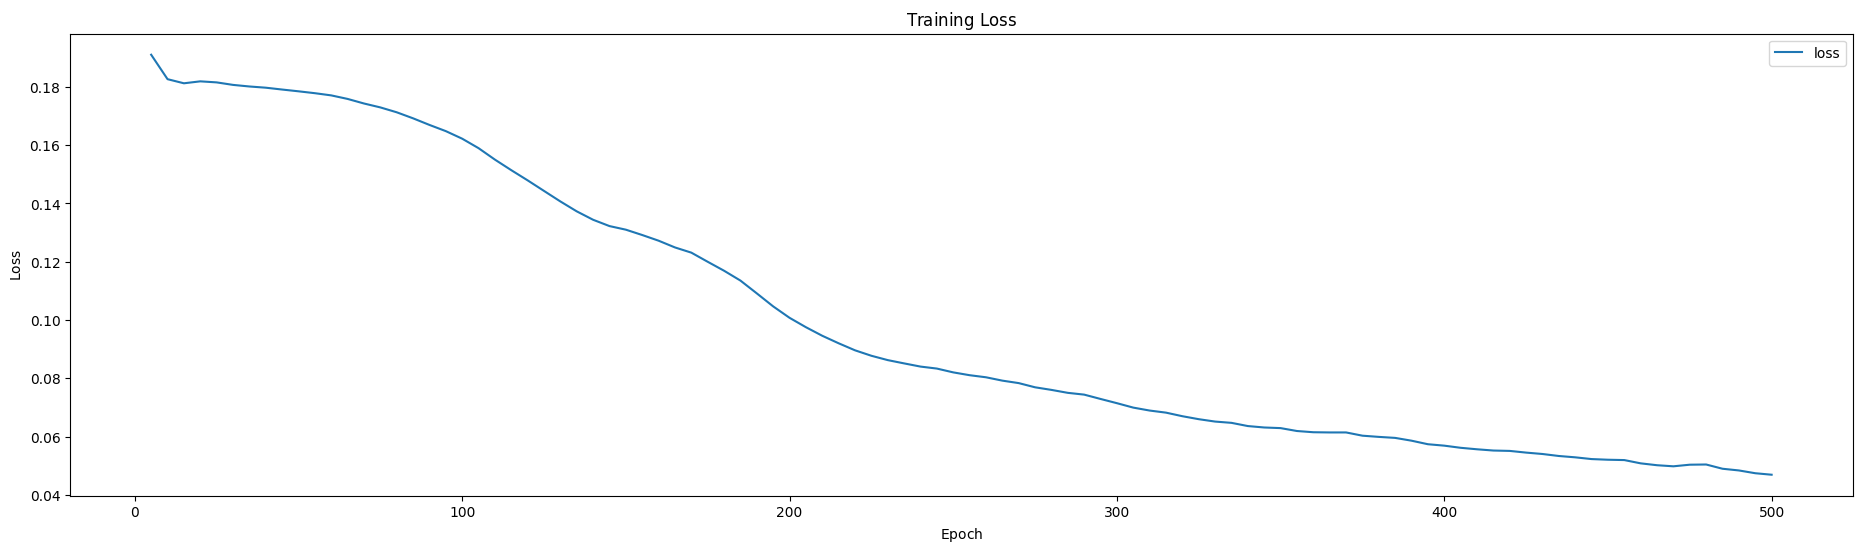

In [5]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="loss", figsize=(23, 6), ax=ax1)
ax1.set_xlabel(r"$\mathrm{Epoch}$")
ax1.set_ylabel(r"$\mathrm{Loss}$")
ax1.set_title(r"$\mathrm{Training}$ $\mathrm{Loss}$")

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_loss.png", dpi=300, bbox_inches="tight") ;

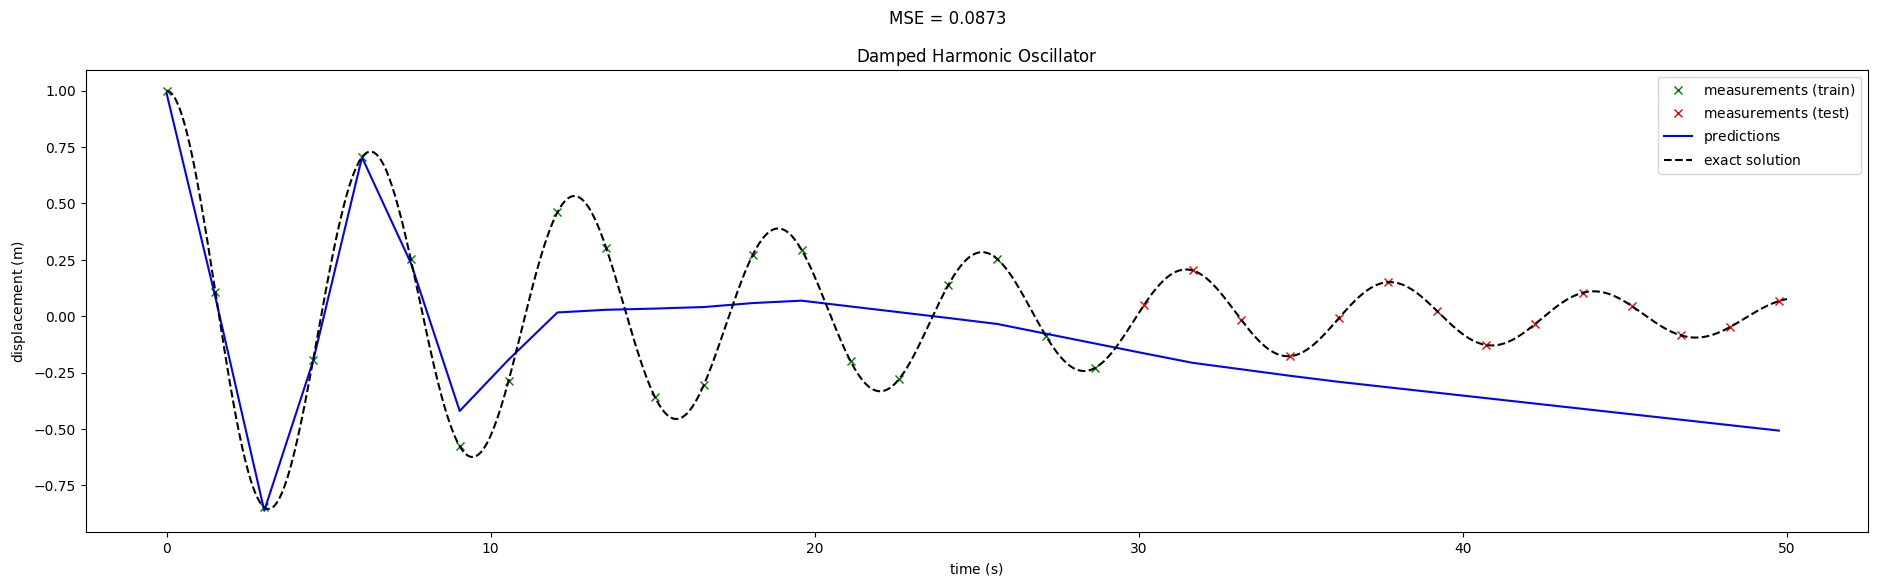

In [6]:
X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1)).detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 30").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 30 and time <= 50").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
)

# plot theoretical curve
m = 1
k = 1
mu = 0.1
x_0 = 1
v_0 = 0

omega_0 = np.sqrt(k/m)
delta = mu/(2*m)
omega = np.sqrt(omega_0**2 - delta**2)

t = np.linspace(0, 50, 1000)
x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
ax1.plot(
    t, 
    x, 
    c="k", linestyle="--", 
    label=r"$\text{exact solution}$"
)

ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

plt.suptitle(f"MSE = {round(mean_squared_error(X['displacement'], X['y_hat']), 4)}")
ax1.legend()

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_predictions.png", dpi=300, bbox_inches="tight") ;

## regularization & hyperparameters tuning

In [7]:
x_train = X.query("time <= 30")[["time"]].copy()
y_train = X.query("time <= 30")[["displacement"]].copy()

x_test = X.query("time > 30 and time <= 50")[["time"]].copy()
y_test = X.query("time > 30 and time <= 50")[["displacement"]].copy()

In [8]:
def hparam_objective(x_train:pd.DataFrame, y_train:pd.DataFrame, trial:optuna.trial.Trial):
    chunk = int(0.7 * x_train.shape[0])
    xt = x_train.iloc[:chunk,:][["time"]].copy()
    xh = x_train.iloc[chunk:,:][["time"]].copy()
    yt = y_train.iloc[:chunk,:][["displacement"]].copy()
    yh = y_train.iloc[chunk:,:][["displacement"]].copy()

    x_train = torch.tensor(xt["time"].values).float().unsqueeze(1)
    y_train = torch.tensor(yt["displacement"].values).float().unsqueeze(1)

    x_test = torch.tensor(xh["time"].values).float().unsqueeze(1)
    # y_test = torch.tensor(yh["displacement"].values).float().unsqueeze(1)

    torch.manual_seed(33)
    hparam_grid = {
        'n_layers': trial.suggest_int("n_layers", 2, 10),
        'n_neurons': trial.suggest_int("n_neurons", 2, 100),
        'activation': trial.suggest_categorical("activation", [nn.ReLU, nn.Tanh]),
        'learning_rate': trial.suggest_float("learning_rate", 1e-5, 1e-1),
        'num_epochs': trial.suggest_int("num_epochs", 1, 20000),
        'weight_decay': trial.suggest_float("weight_decay", 1e-5, 1e-1)
    }

    architecture = [1] + [hparam_grid["n_neurons"] for _ in range(hparam_grid["n_layers"])] + [1]

    model = MultiLayerPerceptronRegressor(architecture, hparam_grid["activation"])
    optimizer = optim.Adam(model.parameters(), lr=hparam_grid["learning_rate"], weight_decay=hparam_grid["weight_decay"])
    criterion = nn.MSELoss()

    for _ in range(hparam_grid["num_epochs"]):
        # forward
        y_train_hat = model(x_train)
        loss = criterion(y_train_hat, y_train)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    yt_hat = model(x_train).detach().numpy()
    yh_hat = model(x_test).detach().numpy()

    metric_1 = r2_score(yt, yt_hat) #+ np.mean(1.0 * (np.exp(-10.0 * yt_hat**2)))
    metric_2 = r2_score(yh, yh_hat) #+ np.mean(1.0 * (np.exp(-10.0 * yh_hat**2)))

    return metric_2, abs(metric_2 - metric_1)


In [9]:
study = optuna.create_study(directions=['maximize', 'minimize'])

[I 2023-10-20 11:56:20,187] A new study created in memory with name: no-name-6271c3a0-8a27-491d-9152-06da183f885f


In [10]:
study.optimize(
    functools.partial(
        hparam_objective,
        x_train,
        y_train
    ), 
    n_trials = 30
)

/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.ReLU'> which is of type type.
  warnings.warn(message)
/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.Tanh'> which is of type type.
  warnings.warn(message)
[I 2023-10-20 11:56:25,131] Trial 0 finished with values: [-0.390185832331168, 0.3901585935411622] and parameters: {'n_layers': 3, 'n_neurons': 16, 'activation': <class 'torch.nn.modules.activation.Tanh'>, 'learning_rate': 0.03666967001617636, 'num_epochs': 7904, 'weight_decay': 0.09311174169698774}. 
/home/dusoudeth/Documentos/github/pinn/li

[I 2023-10-20 11:57:49,907] Trial 8 finished with values: [-0.32805802636656556, 0.3273785146649746] and parameters: {'n_layers': 3, 'n_neurons': 59, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'learning_rate': 0.08790301822133915, 'num_epochs': 16644, 'weight_decay': 0.06348718636572383}. 
/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.ReLU'> which is of type type.
  warnings.warn(message)
/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.Tanh'> which is of type type.
  warnings.warn(message)
[I 2023-10-20 11:58:04,264] Trial 9 fi

[I 2023-10-20 12:00:04,931] Trial 17 finished with values: [-0.40633100745323847, 0.40633100123539045] and parameters: {'n_layers': 7, 'n_neurons': 36, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'learning_rate': 0.06212721941316891, 'num_epochs': 16510, 'weight_decay': 0.01612221986160571}. 
/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.ReLU'> which is of type type.
  warnings.warn(message)
/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.Tanh'> which is of type type.
  warnings.warn(message)
[I 2023-10-20 12:00:22,826] Trial 18

[I 2023-10-20 12:02:37,692] Trial 26 finished with values: [-0.39160106509669923, 0.3915783665191488] and parameters: {'n_layers': 10, 'n_neurons': 41, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'learning_rate': 0.07469167211908492, 'num_epochs': 14503, 'weight_decay': 0.08254218856560386}. 
/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.ReLU'> which is of type type.
  warnings.warn(message)
/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.Tanh'> which is of type type.
  warnings.warn(message)
[I 2023-10-20 12:02:39,074] Trial 27

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_activation,params_learning_rate,params_n_layers,params_n_neurons,params_num_epochs,params_weight_decay,system_attrs_nsga2:generation,state
9,9,-0.257158,0.254401,2023-10-20 11:57:49.908378,2023-10-20 11:58:04.264168,0 days 00:00:14.355790,<class 'torch.nn.modules.activation.ReLU'>,0.085044,9,67,8937,0.044610,0,COMPLETE
8,8,-0.328058,0.327379,2023-10-20 11:57:38.244743,2023-10-20 11:57:49.907651,0 days 00:00:11.662908,<class 'torch.nn.modules.activation.ReLU'>,0.087903,3,59,16644,0.063487,0,COMPLETE
23,23,-0.384379,0.384329,2023-10-20 12:01:21.421417,2023-10-20 12:01:56.014977,0 days 00:00:34.593560,<class 'torch.nn.modules.activation.Tanh'>,0.060638,10,57,19892,0.088479,0,COMPLETE
28,28,-0.388760,0.388728,2023-10-20 12:02:39.075079,2023-10-20 12:02:47.368962,0 days 00:00:08.293883,<class 'torch.nn.modules.activation.Tanh'>,0.004652,8,38,5904,0.099204,0,COMPLETE
0,0,-0.390186,0.390159,2023-10-20 11:56:20.407942,2023-10-20 11:56:25.131199,0 days 00:00:04.723257,<class 'torch.nn.modules.activation.Tanh'>,0.036670,3,16,7904,0.093112,0,COMPLETE
27,27,-0.390238,0.390211,2023-10-20 12:02:37.693519,2023-10-20 12:02:39.074459,0 days 00:00:01.380940,<class 'torch.nn.modules.activation.ReLU'>,0.053917,7,28,1072,0.090473,0,COMPLETE
16,16,-0.390259,0.390232,2023-10-20 11:59:32.560433,2023-10-20 11:59:44.390749,0 days 00:00:11.830316,<class 'torch.nn.modules.activation.ReLU'>,0.062196,3,59,16917,0.049529,0,COMPLETE
13,13,-0.390444,0.390418,2023-10-20 11:59:03.128207,2023-10-20 11:59:12.716412,0 days 00:00:09.588205,<class 'torch.nn.modules.activation.Tanh'>,0.093724,3,47,13730,0.089520,0,COMPLETE
7,7,-0.390746,0.390721,2023-10-20 11:57:27.453632,2023-10-20 11:57:38.244163,0 days 00:00:10.790531,<class 'torch.nn.modules.activation.ReLU'>,0.068728,5,43,11460,0.028912,0,COMPLETE
10,10,-0.390756,0.390731,2023-10-20 11:58:04.264761,2023-10-20 11:58:19.533660,0 days 00:00:15.268899,<class 'torch.nn.modules.activation.ReLU'>,0.047874,4,78,17559,0.089525,0,COMPLETE


{'activation': <class 'torch.nn.modules.activation.ReLU'>,
 'learning_rate': 0.08504406770517726,
 'n_layers': 9,
 'n_neurons': 67,
 'num_epochs': 8937,
 'weight_decay': 0.04460976560010535}
[-0.25715783176688767, 0.25440110288392304]


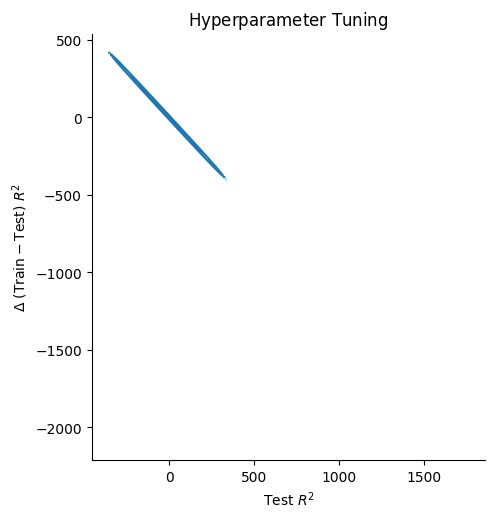

In [12]:
hparam_df = study.trials_dataframe()

sns.displot(
    hparam_df,
    x="values_1",
    y="values_0",
    kind="kde",
)
plt.title(r"$\mathrm{Hyperparameter}$ $\mathrm{Tuning}$")
plt.xlabel(r"$\mathrm{Test}$ $R^2$")
plt.ylabel(r"$\Delta$ ($\mathrm{Train-Test}$) $R^2$")

display(hparam_df.sort_values(by="values_0", ascending=False))
user_pick_index = 9

hparam_dict = study.get_trials()[user_pick_index].params

pprint.pprint(hparam_dict)
pprint.pprint(study.get_trials()[user_pick_index].values)

epoch [00500/08937] loss: 0.1839
epoch [01000/08937] loss: 0.1839
epoch [01500/08937] loss: 0.1839
epoch [02000/08937] loss: 0.1839
epoch [02500/08937] loss: 0.1839
epoch [03000/08937] loss: 0.1839
epoch [03500/08937] loss: 0.1839
epoch [04000/08937] loss: 0.7055
epoch [04500/08937] loss: 0.1844
epoch [05000/08937] loss: 0.1844
epoch [05500/08937] loss: 0.1844
epoch [06000/08937] loss: 0.1844
epoch [06500/08937] loss: 0.1843
epoch [07000/08937] loss: 0.1843
epoch [07500/08937] loss: 0.1843
epoch [08000/08937] loss: 0.1845
epoch [08500/08937] loss: 0.1844


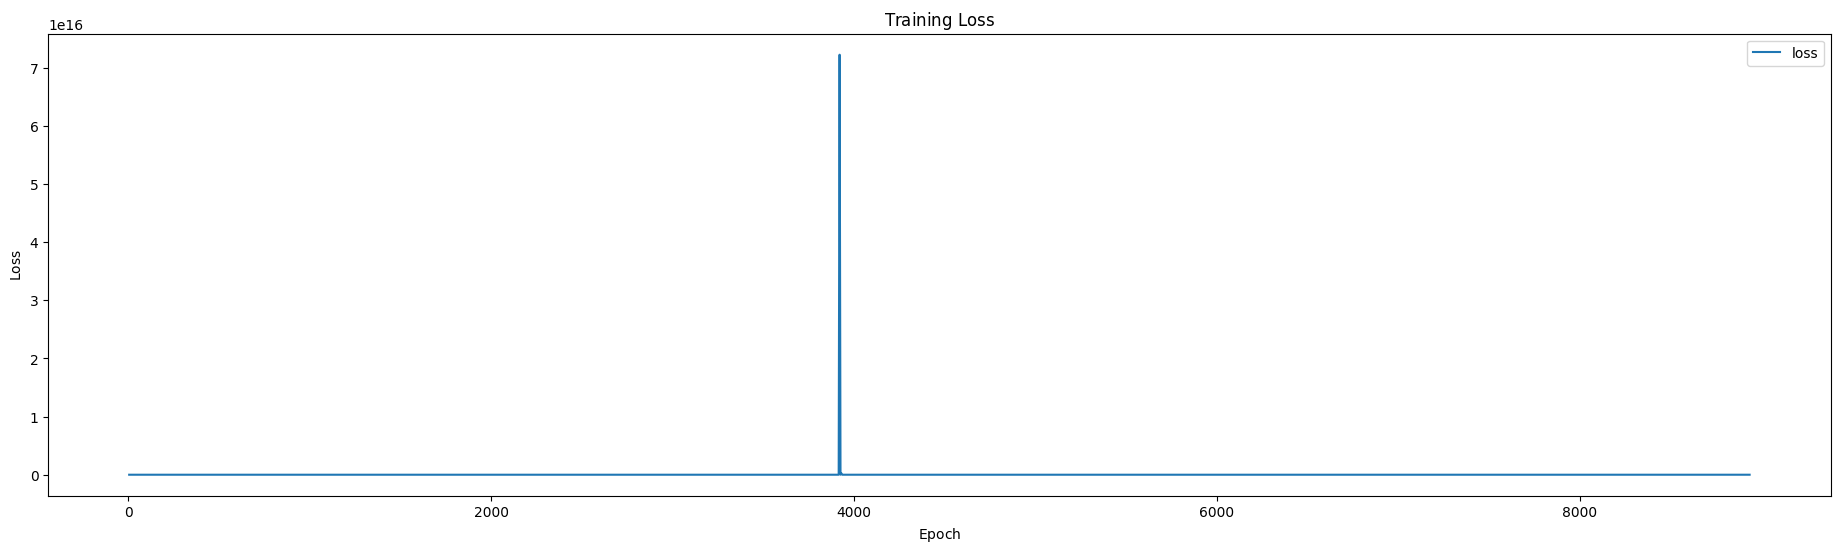

In [14]:
torch.manual_seed(33)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(X.query("time <= 30")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query("time <= 30")["displacement"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query("time > 30 and time <= 50")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query("time > 30 and time <= 50")["displacement"].values).float().unsqueeze(1).to(device)

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

model = MultiLayerPerceptronRegressor(architecture, nn.ReLU)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=hparam_dict["weight_decay"])
criterion = nn.MSELoss()

plot_loss_train = dict(epoch=[], loss=[])

for epoch in range(hparam_dict["num_epochs"]):
    # forward
    y_train_hat = model(x_train)
    loss = criterion(y_train_hat, y_train)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 500 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["loss"].append(loss.item())

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="loss", figsize=(23, 6), ax=ax1)
ax1.set_xlabel(r"$\mathrm{Epoch}$")
ax1.set_ylabel(r"$\mathrm{Loss}$")
ax1.set_title(r"$\mathrm{Training}$ $\mathrm{Loss}$")

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_loss_tuning.png", dpi=300, bbox_inches="tight") ;

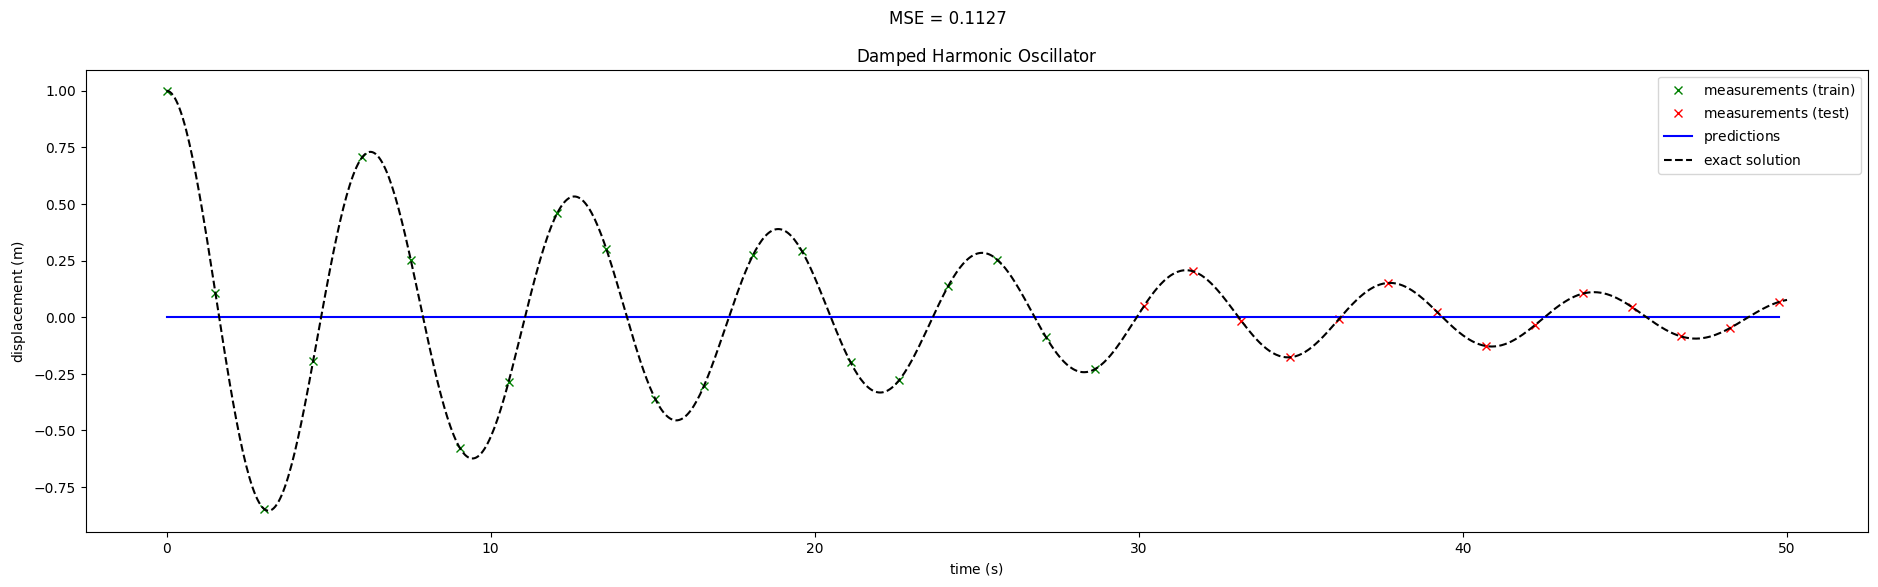

In [17]:
X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 30").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 30 and time <= 100").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
)

# plot theoretical curve
m = 1
k = 1
mu = 0.1
x_0 = 1
v_0 = 0

omega_0 = np.sqrt(k/m)
delta = mu/(2*m)
omega = np.sqrt(omega_0**2 - delta**2)

t = np.linspace(0, 50, 1000)
x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
ax1.plot(
    t, 
    x, 
    c="k", linestyle="--", 
    label=r"$\text{exact solution}$"
)

ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

plt.suptitle(f"MSE = {round(mean_squared_error(X['displacement'], X['y_hat']), 4)}")
ax1.legend()

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_predictions_tuning.png", dpi=300, bbox_inches="tight") ;

# pinn

$$ \ddot{x} + \frac{\mu}{m} \dot{x} + \frac{k}{m} x = 0 $$

epoch [00250/15000] loss: 0.1297 physics loss: 0.0036
epoch [00500/15000] loss: 0.1214 physics loss: 0.0042
epoch [00750/15000] loss: 0.1091 physics loss: 0.0035
epoch [01000/15000] loss: 0.0924 physics loss: 0.0034
epoch [01250/15000] loss: 0.0874 physics loss: 0.0036
epoch [01500/15000] loss: 0.0863 physics loss: 0.0034
epoch [01750/15000] loss: 0.0856 physics loss: 0.0032
epoch [02000/15000] loss: 0.0849 physics loss: 0.0031
epoch [02250/15000] loss: 0.0849 physics loss: 0.0032
epoch [02500/15000] loss: 0.0841 physics loss: 0.003
epoch [02750/15000] loss: 0.0837 physics loss: 0.003
epoch [03000/15000] loss: 0.0834 physics loss: 0.0031
epoch [03250/15000] loss: 0.0832 physics loss: 0.0032
epoch [03500/15000] loss: 0.0848 physics loss: 0.0041
epoch [03750/15000] loss: 0.083 physics loss: 0.0032
epoch [04000/15000] loss: 0.0827 physics loss: 0.0033
epoch [04250/15000] loss: 0.0825 physics loss: 0.0035
epoch [04500/15000] loss: 0.0823 physics loss: 0.0036
epoch [04750/15000] loss: 0.082

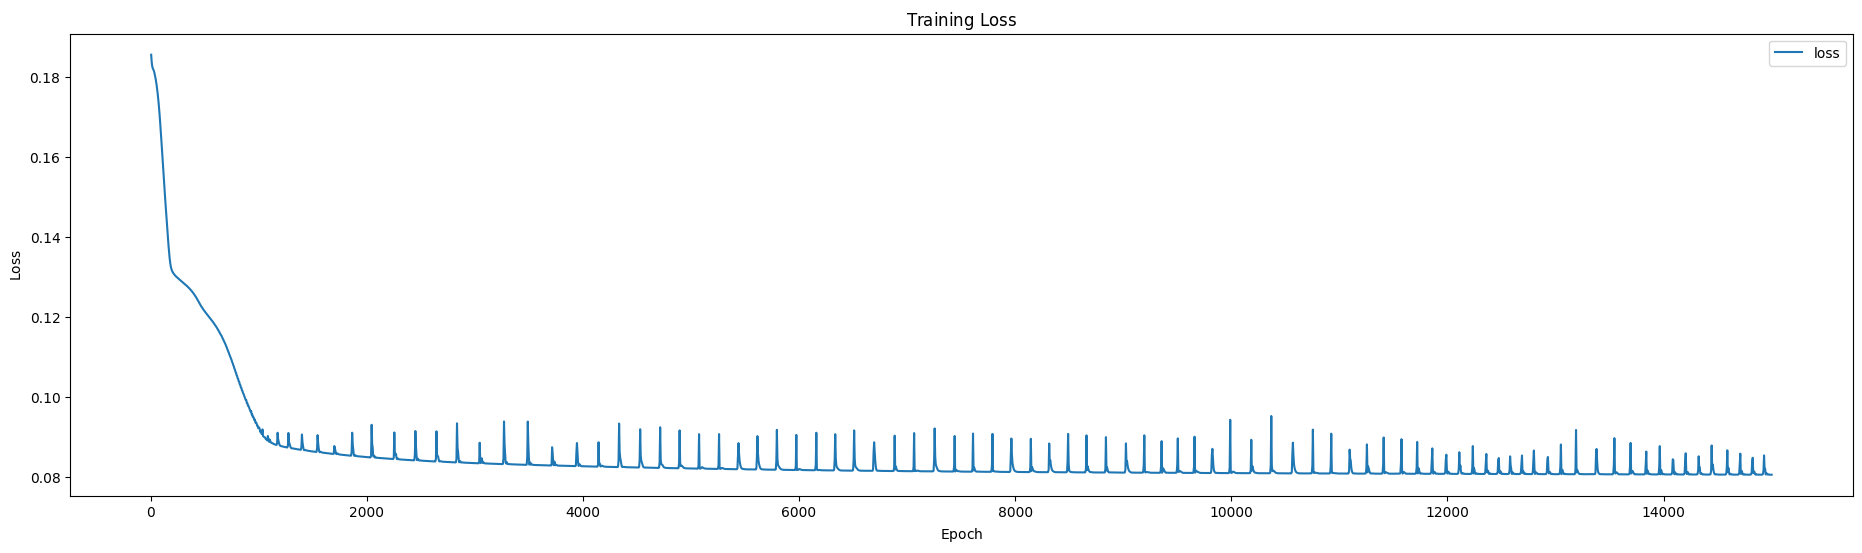

In [20]:
m = 1
k = 1
mu = 0.1
x_0 = 1
v_0 = 0

torch.manual_seed(33)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(X.query("time <= 30")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query("time <= 30")["displacement"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query("time > 30 and time <= 50")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query("time > 30 and time <= 50")["displacement"].values).float().unsqueeze(1).to(device)

hparam_dict = {
    'learning_rate': 1e-4,
    'n_layers': 8,
    'n_neurons': 32,
    'num_epochs': 15000,
    'weight_decay': 0.0019687105625249557
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=hparam_dict["weight_decay"])
criterion = nn.MSELoss()

plot_loss_train = dict(epoch=[], loss=[])

_locations = torch.linspace(0, 50, 30).view(-1,1).requires_grad_(True).unsqueeze(1).to(device)

for epoch in range(hparam_dict["num_epochs"]):
    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]
    dy2dt2 = torch.autograd.grad(dydt, _locations, grad_outputs=torch.ones_like(dydt), create_graph=True)[0]
    _diff_equation = m*dy2dt2 + mu*dydt + k*y_location_hat
    physics_loss = torch.mean(_diff_equation**2)

    loss = data_loss + physics_loss
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 250 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["loss"].append(loss.item())

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="loss", figsize=(23, 6), ax=ax1)
ax1.set_xlabel(r"$\mathrm{Epoch}$")
ax1.set_ylabel(r"$\mathrm{Loss}$")
ax1.set_title(r"$\mathrm{Training}$ $\mathrm{Loss}$")

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_loss_pinn.png", dpi=300, bbox_inches="tight") ;

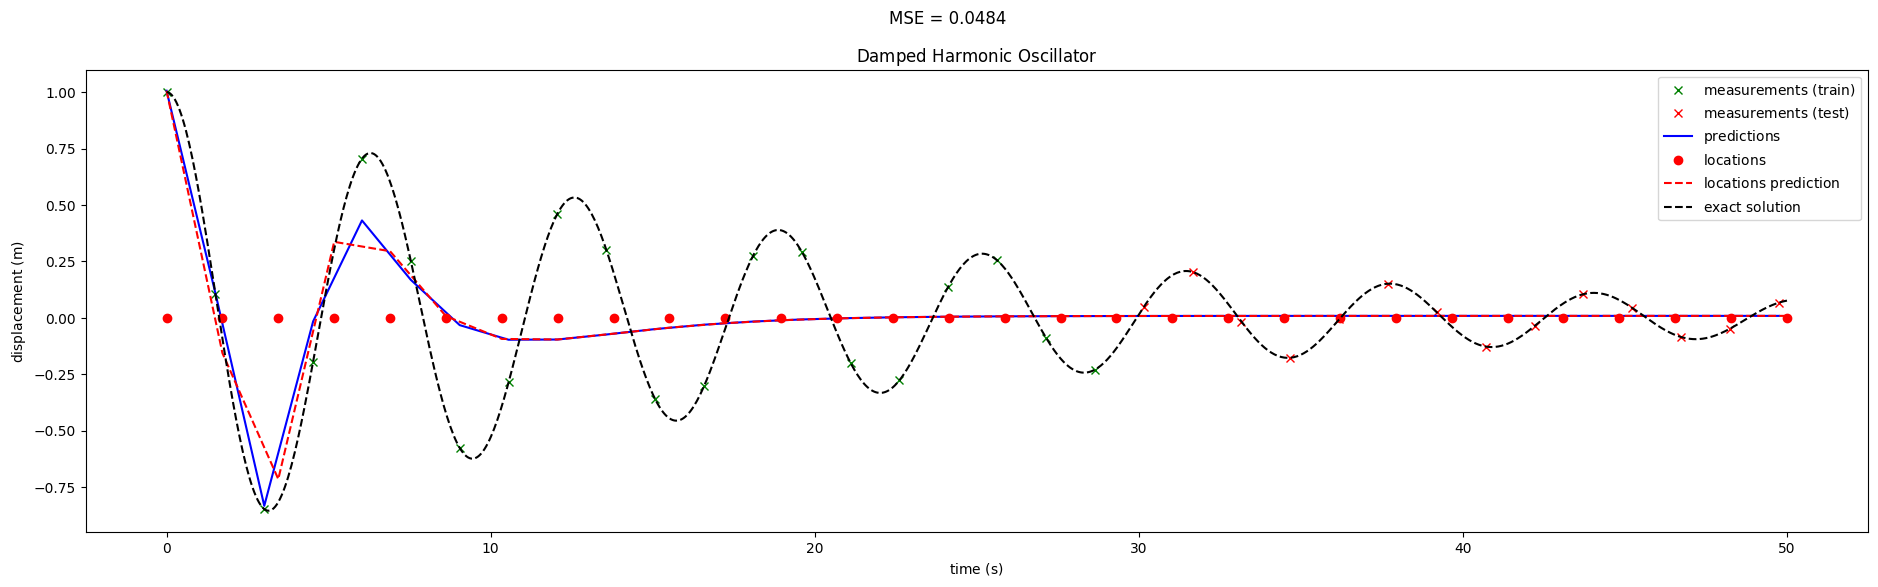

In [21]:
X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 30").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 30 and time <= 50").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1), 
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1), 
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--",
    label=r"$\text{locations prediction}$"
)

# plot theoretical curve
m = 1
k = 1
mu = 0.1
x_0 = 1
v_0 = 0

omega_0 = np.sqrt(k/m)
delta = mu/(2*m)
omega = np.sqrt(omega_0**2 - delta**2)

t = np.linspace(0, 50, 1000)
x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
ax1.plot(
    t, 
    x, 
    c="k", linestyle="--", 
    label=r"$\text{exact solution}$"
)

ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

plt.suptitle(f"MSE = {round(mean_squared_error(X['displacement'], X['y_hat']), 4)}")
ax1.legend()

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_predictions_pinn.png", dpi=300, bbox_inches="tight") ;

In [198]:
_locations.cpu().detach().numpy().reshape(-1)

model(_locations).cpu().detach().numpy().reshape(-1)

array([ 0.99995923, -0.09352884, -0.80673015,  0.34794965,  0.5320889 ,
       -0.23421152, -0.17324647, -0.03106426,  0.04097931,  0.05977762,
        0.05307123,  0.03774813,  0.02175251,  0.00807196, -0.00262131,
       -0.01057975, -0.01633093, -0.02041033, -0.02326861, -0.02525549,
       -0.02663034, -0.0275757 , -0.02822517, -0.0286701 , -0.02897567,
       -0.02918404, -0.02932677, -0.02942353, -0.02949032, -0.0295358 ],
      dtype=float32)

.